# [This is a WIP]

# Finding out what I like using Trello

## Using Trello to organize my articles

I tend to spend a lot of time on the Internet reading articles about almost everything.

But there is a problem: it is very easy to be overwhelmed by tons of stuff to read and watch. 

In the beginning, I was doing it the lazy way, opening a new tab with the content I wanted to read, telling myself: "yes I will go back to it soon, it sounds very interesting and if I don't read it, I will miss out on something cool". But this tab would stay opened for months (really). Sometimes it would be closed by inadvertance or lazyness and would be forgotten in the limbo.

This was a bad habit. One day I discovered Trello, the very good project management tool, and I decided to give it a try. I would use it not for work or anything related, but just as a personal assistant to remember some of my stuff.

Quickly it became part of my daily routine, and along with the mobile app it became very easy to access any content that I have on Trello. Naturally, the idea of using it to save and organize articles came by itself.

I created a board called *To Read and Watch*, with four lists:
- To Read
- To Watch
- Done
- Save

<img src="img/overview.png" style="display: block;margin: auto; max-width: 100%;">

How does it work? Very easy. Everytime I spot an article that looks interesting and I know I will have to read it sooner or later, I just put it in the list *To Read*. The title of the card corresponds to the title of the article and the link is in the description.

<img src="img/article.png" style="display: block;margin: auto; max-width: 100%;">

I use labels to classify my articles, so when I want to read something I can easily make a choice depending on my current mood. Some labels examples:
- Programming and development
- Maths
- News
- Culture
- ...

When I am done reading or watching, I move the card to the list *Done*, or the list *Save* if it was a good read that could lead to further investigations.

I have been doing this for several months already and this has been very convenient to me. It is way more flexible because Trello can be accessed from my personal computer, phone, tablet, work computer ... In a way, I always feel like there is something to learn and read, wherever I could be as long as I have one of these devices with me. If I have to wait for the bus for example and feel bored, I know there is already a selection of interesting stuff that are just waiting to be "processed".

## Knowing more about myself

Structuring this way makes it easy to keep track of everything. Sometimes I recall something I have read somewhere on the Internet, but it's been too long or my memories are too fusy. Trello provides a good search functionality, so I know there is a way to find the related article, as long as I remember what it was about.

I am usually very curious, and seeing all of this data being created and stored (by me!) makes me want to make more advanced research and stats.

There are a lot of questions that can be asked about my reading habits, which is in my opinion very related to personal interests:
- How many articles read / in the queue?
- What is the label I use the most?
- How long does an article stay in the *To Read* in average?
- What day of the week are there the most articles moved from *To Read* to *Done*?
- What kind of topic is the most present in my lists?


All of this is very exciting. As I am writing right now I haven't even started playing with the data, Python and graphs, but I know the results will be worth it.

## How to do that?

Trello provides an API, and that's a good news. With the API it's even possible to access more data than using the standard web UI.

So that's our tool! Couple to that I will use Python, because requests, beautifulsoup and matplotlib are wonderful tools. More Python libraries will be also used, especially if I decide to do some machine learning to be able to predict my future readings.

## Getting started with the Trello API

Let's get started!

First thing to do is to become more familiar with the API. This first part will be all about data wrangling and how to arrange the data in a nice way so it becomes easy to use.


In [1]:
import os
import requests
import json

TRELLO_API = 'https://api.trello.com/1/'
TRELLO_API_KEY = os.getenv('TRELLO_API_KEY', '')
TRELLO_API_SECRET = os.getenv('TRELLO_API_SECRET', '')
TRELLO_TOKEN = os.getenv('TRELLO_TOKEN', '')

auth = '?key=' + TRELLO_API_KEY + '&token=' + TRELLO_TOKEN

BOARD_ID = os.getenv('TRELLO_BOARD_ID', '')

Now that everything is set up, let's start getting some data.

### Get the total number of cards for each of the four lists

An easy one to get started. 

In [2]:
# Get the board
board = requests.get(TRELLO_API + 'boards/' + BOARD_ID + auth).json()

# Print the board
# print(json.dumps(board, indent=4))

labels = board['labelNames'];
raw_lists = requests.get(TRELLO_API + 'boards/' + BOARD_ID + '/lists' + auth).json()

lists_filter = ['To Read', 'To Watch', 'Done', 'Save']

# Reformat the lists to a dic list_name -> list_id
lists_ids = {x['name']: x['id'] for x in raw_lists if x['name'] in lists_filter}

def get_actions(list_id):
    res = []
    page = 0
    data = [1]
    while len(data) != 0:
        data = requests.get(TRELLO_API + 'lists/' + list_id + '/actions' 
                            + auth + '&page=' + str(page) + 'limit=1000').json() 
        res += data
        page += 1
        
    return res


def get_list(list_id):
    return {
        'cards': requests.get(TRELLO_API + 'lists/' + list_id + '/cards/all' + auth).json(),
        'actions': get_actions(list_id)
    }

ls = {list_name: get_list(lists_ids[list_name]) for list_name in lists_ids.keys()}

number_cards_per_list = {x: len(c['cards']) for x, c in ls.items()}

for x, c in ls.items():
    print('The list "' + x + '" contains ' + str(len(c['cards'])) + ' cards')

The list "Save" contains 56 cards
The list "Done" contains 200 cards
The list "To Watch" contains 20 cards
The list "To Read" contains 49 cards


Visualized:

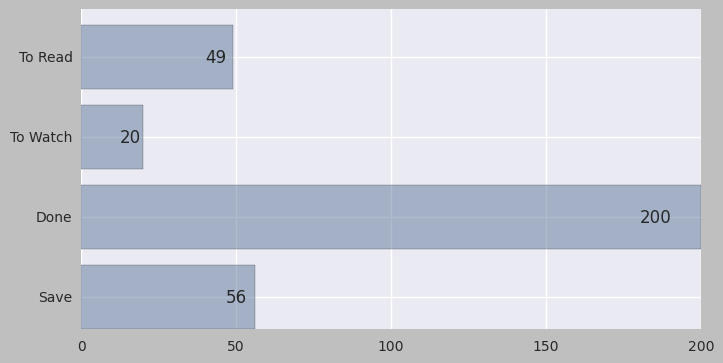

In [3]:
# First time we plot something, let's set everything up
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcdefaults()

# make it pretty!
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

keys = list(number_cards_per_list.keys())
y = np.arange(len(number_cards_per_list.keys()))
rects = plt.barh(y, list(number_cards_per_list.values()), alpha=0.5)
plt.yticks(y + 0.4, keys)

for i, rect in enumerate(rects):
    plt.text(0.95 * rect.get_width(), rect.get_y() + rect.get_height() / 2.0, number_cards_per_list[keys[i]], ha='right', va='center')

plt.show()

Now that we retrieved almost all the data we need, we can calculate stats on the cards.
One thing to notice is that some cards are sometimes added to the list *Done* without going through the list *To Read*. This happens when I spot an article, read it directly, and thinks it is important enough to be remembered.

## Number of cards per label

Some cards have more than one label.

In [4]:
from collections import Counter

big_list_of_cards = [card for c in ls.values() for card in c['cards']]
print('Total number of cards: ' + str(len(big_list_of_cards)))

label_count = dict(Counter([(label['name'], label['color']) for c in big_list_of_cards for label in c['labels']]).most_common())

for label, number_of_cards in label_count.items():
    print(str(label) + ' used ' + str(number_of_cards) + ' times')

Total number of cards: 325
('Short Story', 'lime') used 2 times
('Culture', 'yellow') used 113 times
('Science', 'red') used 20 times
('Other', 'blue') used 32 times
('Math', 'purple') used 30 times
('Fun', 'orange') used 11 times
('Programming', 'green') used 162 times
('Gaming', 'black') used 4 times
('Music', 'sky') used 2 times
('Computer Science', None) used 26 times
('News', 'pink') used 10 times


And putting the data in a graph:

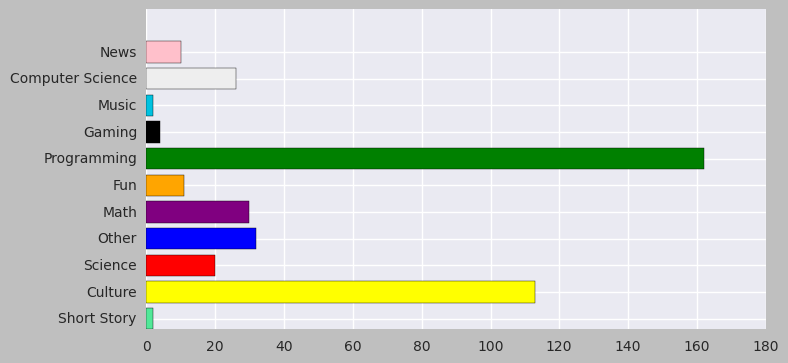

In [5]:
# matplotlib doesn't know about these colors by default
color_replacement = {
    'sky': '#00C2E0',
    'lime': '#51E898',
    None: '#EEEEEE'
}

x = np.arange(len(label_count.keys()))
plt.barh(x, list(label_count.values()), color=[a[1] if a[1] not in color_replacement else color_replacement[a[1]] for a in label_count.keys()])
plt.yticks(x + 0.4, list(a[0] for a in label_count.keys()))
plt.show()

## How many cards were moved from *To Read* to *Done*?

In [6]:
print(str(len(ls['To Read']['actions'])) + ' actions on the list "To Read"')
      
# Filter the cards that were in the list "To Read" before
moved_to_done = [c for c in ls['To Read']['actions'] 
                 if 'data' in c and 'listAfter' in c['data'] and c['data']['listAfter']['id'] == lists_ids['Done']]

moved_to_save = [c for c in ls['To Read']['actions'] 
                 if 'data' in c and 'listAfter' in c['data'] and c['data']['listAfter']['id'] == lists_ids['Save']]

moved_to_done = moved_to_done + moved_to_save 

print(str(len(moved_to_done)) + ' cards were moved from "To Read" to "Done" and "Save"')

628 actions on the list "To Read"
185 cards were moved from "To Read" to "Done" and "Save"


## What is the average time it takes for a card to move from *To Read* to *Done*

It takes 40 days in average for a card to be moved from "To Read" to "Done"
The median is: 7, which means that half of the articles are read in less than 7 days
max: 354, min: 0, stdev: 72.21550079201555 , variance: 5215.078554641598


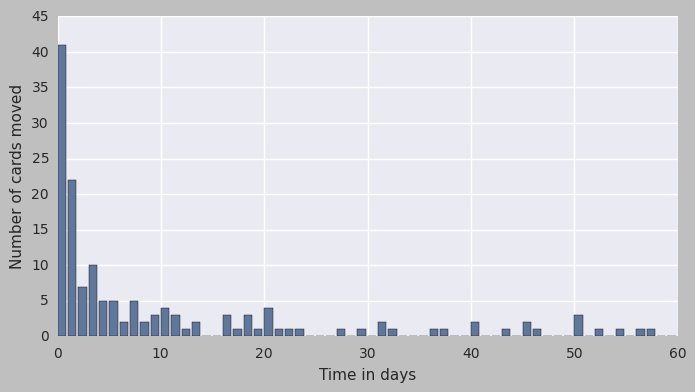

In [83]:
import datetime
import math
import statistics
import collections

date_format = '%Y-%m-%dT%H:%M:%S'
def parse_date(date_str):
    return datetime.datetime.strptime(date_str[:date_str.index('.')], date_format)

# Create a dictionary card_id -> date to track the date a card was moved
dates_moved = {c['data']['card']['id']: parse_date(c['date']) for c in moved_to_done}

# Create a dictionary card_id -> date to track the date a card was created
dates_created = {c['data']['card']['id']: parse_date(c['date']) for c in ls['To Read']['actions'] 
                 if 'card' in c['data'] and c['data']['card']['id'] in dates_moved.keys() and c['type'] == 'createCard'}

# Calculate the difference in days, assuming date_moved > date_created
times = [(d - dates_created[cid]).days for cid, d in dates_moved.items()]

average_days_for_moving = math.floor(statistics.mean(times))
median = math.floor(statistics.median(times))
standard_deviation = statistics.stdev(times)
variance = statistics.variance(times)
max_days = max(times)
min_days = min(times)

print('It takes ' + str(average_days_for_moving) + ' days in average for a card to be moved from "To Read" to "Done"')
print('The median is: ' + str(median) + ', which means that half of the articles are read in less than ' + str(median) + ' days')
print('max: ' + str(max_days) + ', min: ' + str(min_days) + ', stdev: ' + str(standard_deviation), ', variance: ' + str(variance))

times_count = {x: 0 for x in range(max(times)+1)}
for t in times:
    times_count[t] += 1

x = np.arange(len(times_count.keys()))
plt.xlabel('Time in days')
plt.ylabel('Number of cards moved')
plt.bar(x, list(times_count.values()))
plt.show()

The same data but zoomed to show only a 2 months period

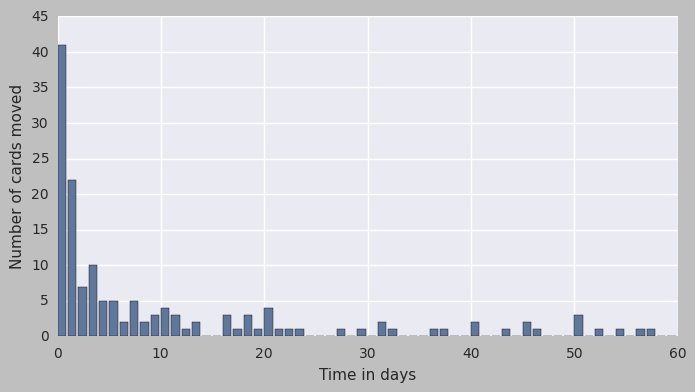

In [84]:
plt.xlim(0, 60)
plt.xlabel('Time in days')
plt.ylabel('Number of cards moved')
plt.bar(x, list(times_count.values()))
plt.show()

## Average processing time per label?

How much time does it take to move a card, grouped by label? 

For label Culture: avg time: 29 days, mean: 7 days
For label Music: avg time: 12 days, mean: 12 days
For label Programming: avg time: 56 days, mean: 7 days
For label Science: avg time: 36 days, mean: 6 days
For label Short Story: avg time: 20 days, mean: 20 days
For label News: avg time: 1 days, mean: 1 days
For label Math: avg time: 33 days, mean: 9 days
For label Other: avg time: 26 days, mean: 3 days
For label Fun: avg time: 19 days, mean: 1 days
For label Gaming: avg time: 2 days, mean: 2 days


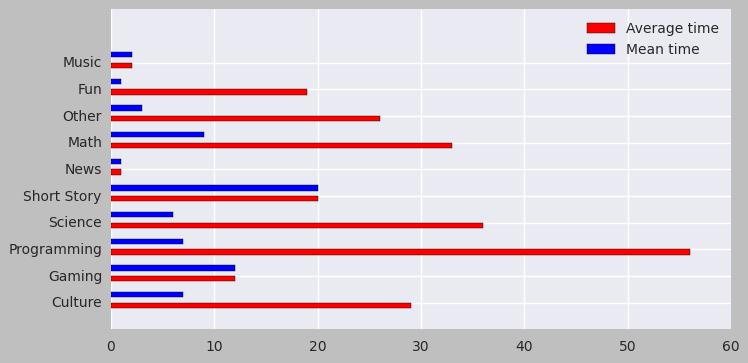

In [137]:
def labels_list_names(ls):
    return [l['name'] for l in ls]

labels_inv = { v: k for k, v in labels.items() }

cards_indexed_by_id = {c['id']: c for c in big_list_of_cards}

average_time_per_label = {}
median_time_per_label = {}

for label in labels_inv.keys():
    # Basically the same code as before
    dates_moved = { c['data']['card']['id']: parse_date(c['date']) 
                       for c in moved_to_done 
                       if label in labels_list_names(cards_indexed_by_id[c['data']['card']['id']]['labels'])}

    # Create a dictionary card_id -> date to track the date a card was created
    dates_created = {c['data']['card']['id']: parse_date(c['date']) for c in ls['To Read']['actions'] 
                     if 'card' in c['data'] 
                        and c['data']['card']['id'] in dates_moved.keys() 
                        and c['type'] == 'createCard'
                    }

    # Calculate the difference in days, assuming date_moved > date_created
    times = [(d - dates_created[cid]).days for cid, d in dates_moved.items()]

    standard_deviation = statistics.stdev(times) if len(times) > 1 else 0
    variance = statistics.variance(times) if len(times) > 1 else 0
    max_days = max(times)
    min_days = min(times)
    
    average_time_per_label[label] = math.floor(statistics.mean(times))
    median_time_per_label[label] = math.floor(statistics.median(times))

for label, time in average_time_per_label.items():
    print('For label ' + label + ': avg time: ' + str(time) + ' days, mean: ' + str(median_time_per_label[label]) + ' days')

x = np.arange(len(labels_inv.keys()))-1
averages = plt.barh(x-0.2, list(average_time_per_label.values()), label=['average', 'mean'], height=0.2, color='r')
means = plt.barh(x+0.2, list(median_time_per_label.values()), height=0.2, color='b')
plt.legend((averages, means), ('Average time', 'Mean time'))
plt.yticks(x, list(label for label in labels_inv.keys()))
plt.show()

## At what day of the week a card is more likely to be moved?

Let's draw what we call a punchcard (like the Github punchcard)

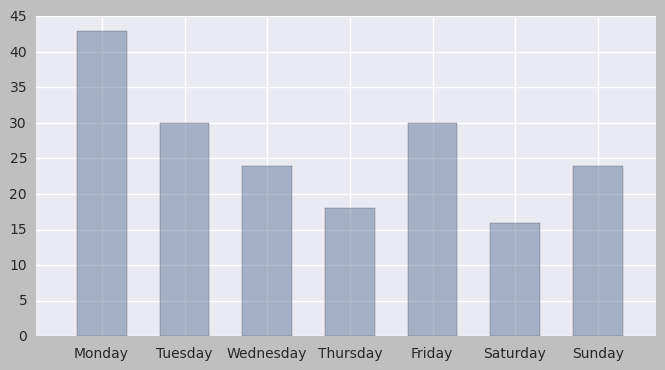

In [9]:
import dateutil.parser
from pytz import timezone

# localize the time to Sweden
sweden=timezone('Europe/Stockholm')

WEEK_DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_of_week_punchcard = sorted(
        Counter(
            [dateutil.parser.parse(moved_action['date']).astimezone(sweden).weekday() for moved_action in moved_to_done]
        ).most_common()
        , key=lambda day: day[0]
    )

x = np.arange(len(WEEK_DAYS))
plt.xlim(x.min() - 0.5, x.max() + 1)
plt.bar(x, [d[1] for d in days_of_week_punchcard], alpha=0.5, width=0.6)
plt.xticks(x + 0.3, WEEK_DAYS, fontsize=10)
plt.show()

Surprisingly I manage to get things done on Mondays!

## And now, at what time of the day?

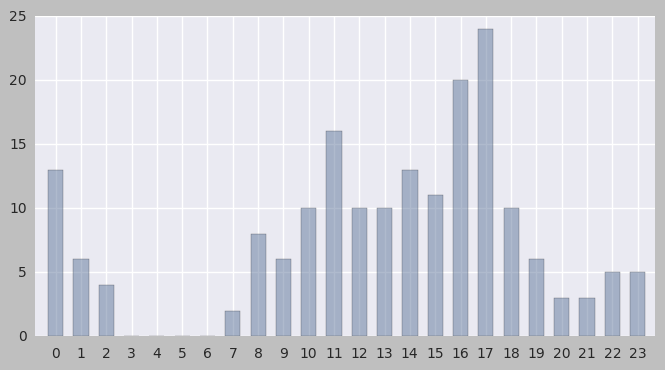

In [10]:
hours_of_day_punchcard = { x: 0 for x in range(24)}
for moved_action in moved_to_done:
    hours_of_day_punchcard[dateutil.parser.parse(moved_action['date']).astimezone(sweden).hour] += 1

x = np.arange(24)
plt.xlim(- 0.5, 24)
plt.bar(x, hours_of_day_punchcard.values(), alpha=0.5, width=0.6)
plt.xticks(x + 0.3, x, fontsize=10)
plt.show()

Interesting results again.
- I sleep at least between 3 and 6 (which is comforting)
- I usually eat between 8 p.m and 9 p.m, so no time for reading stuff at that moment!
- There is a big peak at the end of the day, which could mean that I might be tired after a day at work and I am more likely to finish the afternoon with a good read.

## Punchcard (days and hours combined)

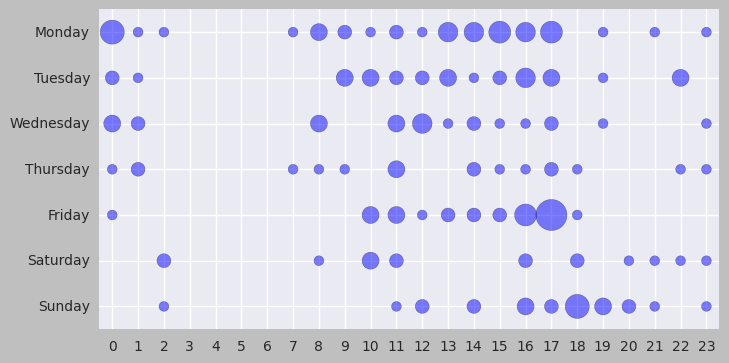

In [11]:
global_punchcard = { (x, y): 0 for x in range(24) for y in range(7) }
for moved_action in moved_to_done:
    parsed_date = dateutil.parser.parse(moved_action['date']).astimezone(sweden)
    global_punchcard[(parsed_date.hour, parsed_date.weekday())] += 1
    
x = [d[0] for d in global_punchcard.keys()]
y = [d[1] for d in global_punchcard.keys()]
s = [50 * s for s in global_punchcard.values()]

plt.xlim(min(x)-0.5, max(x)+0.5)
plt.ylim(min(y)-0.5, max(y)+0.5)
plt.xticks(np.arange(24))
plt.yticks(np.arange(7), WEEK_DAYS)
plt.gca().invert_yaxis()
plt.scatter(x, y, s=s, alpha=0.5)
plt.show()

## What is this card that I moved on a Friday between midnight and 1 a.m?

In [12]:
day_to_search, hour_to_search = 4, 0
moved_thursdays_at_5 = [moved_action for moved_action in moved_to_done 
                        if dateutil.parser.parse(moved_action['date']).astimezone(sweden).weekday() == day_to_search 
                        and dateutil.parser.parse(moved_action['date']).astimezone(sweden).hour == hour_to_search]

print('Card name: ' + moved_thursdays_at_5[0]['data']['card']['name'])
print('Moved on: ' + dateutil.parser.parse(moved_thursdays_at_5[0]['date']).astimezone(sweden).strftime("%A %d. %B %Y at %X"))

Card name: Monthly Challenge: Natural Language Processing in Python
Moved on: Friday 20. March 2015 at 00:53:14
